In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
dataset_path = '/content/drive/MyDrive/realwaste/realwaste-main/RealWaste'

In [30]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [31]:
IMAGE_SIZE = 524
BATCH_SIZE = 16
CHANNELS = 3
EPOCHS = 5

In [32]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 4752 files belonging to 9 classes.


In [33]:
class_names = dataset.class_names
class_names

['Cardboard',
 'Food Organics',
 'Glass',
 'Metal',
 'Miscellaneous Trash',
 'Paper',
 'Plastic',
 'Textile Trash',
 'Vegetation']

In [34]:
len(dataset)

297

(16, 524, 524, 3)
[3 2 1 5 7 5 3 8 0 3 6 6 3 8 8 6]


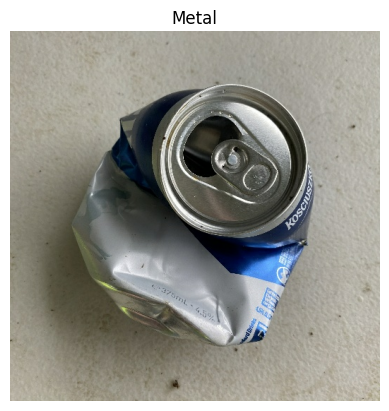

In [35]:
for image_batch, lable_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.axis("off")
    plt.title(class_names[lable_batch[0]])
    print(image_batch.shape)
    print(lable_batch.numpy())

In [36]:
# plt.figure(figsize = (10,10))
# for image_batch, lable_batch in dataset.take(1):
#     for i in range(12):
#         ax = plt.subplot(3,4,i+1)
#         plt.imshow(image_batch[i].numpy().astype("uint8"))
#         plt.axis("off")
#         plt.title(class_names[lable_batch[i]])

In [37]:
def get_dataset_partitions(ds, train_split=0.6, val_split=0.2, test_split=0.2, shuffle=True, shuffle_size = 10000):

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [38]:
train_ds, val_ds, test_ds = get_dataset_partitions(dataset)

In [39]:
len(train_ds) ,len(val_ds), len(test_ds)

(178, 59, 60)

In [40]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# train_ds = train_ds.shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)  # No shuffle for val_ds
# test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)  # No shuffle for test_ds


In [44]:
import tensorflow as tf
# print(tf.__version__)
# print(tf.keras.__version__)

In [45]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(224, 224),
    layers.Rescaling(1.0/255)
])

In [46]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [47]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [48]:
input_shape = (524, 524, CHANNELS)
n_classes = 9

model = models.Sequential([
    tf.keras.Input(shape=input_shape),
    resize_and_rescale,
    layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    # layers.Conv2D(64, (3,3), activation = 'relu'),
    # layers.MaxPooling2D((2,2)),
    # layers.Conv2D(64, (3,3), activation = 'relu'),
    # layers.MaxPooling2D((2,2)),
    # layers.Conv2D(64, (3,3), activation = 'relu'),
    # layers.MaxPooling2D((2,2)),
    # layers.Conv2D(64, (3,3), activation = 'relu'),
    # layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation = 'softmax')
])

In [49]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 186624)           

In [50]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose=1,
    validation_data = val_ds
)

Epoch 1/5
178/178 [==============================] - 329s 2s/step - loss: 2.4856 - accuracy: 0.1949 - val_loss: 2.1565 - val_accuracy: 0.2108
Epoch 2/5
108/178 [=================>............] - ETA: 1:52 - loss: 2.1489 - accuracy: 0.2101

In [ ]:
scores = model.evaluate(test_ds)